In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from FIESTA_functions import *
from HARPS_N_functions import *

#----------------------------------
# Read data
#----------------------------------

v_grid  = np.loadtxt('./data_v4/v_grid.txt')
CCF     = np.loadtxt('./data_v4/CCF.txt')
σCCF   = np.loadtxt('./data_v4/σCCF.txt')
bjd     = np.loadtxt('./data_v4/bjd.txt')
rv      = np.loadtxt('./data_v4/rv.txt')
σrv     = np.loadtxt('./data_v4/σrv.txt')
idx_rej = np.array(np.loadtxt('idx_rej'), dtype=bool)

In [3]:
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from datetime import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days +1)):
        yield start_date + timedelta(n)

### L-BFGS-B

L-BFGS-B is a variant of BFGS that allows the incorporation of "box" constraints.

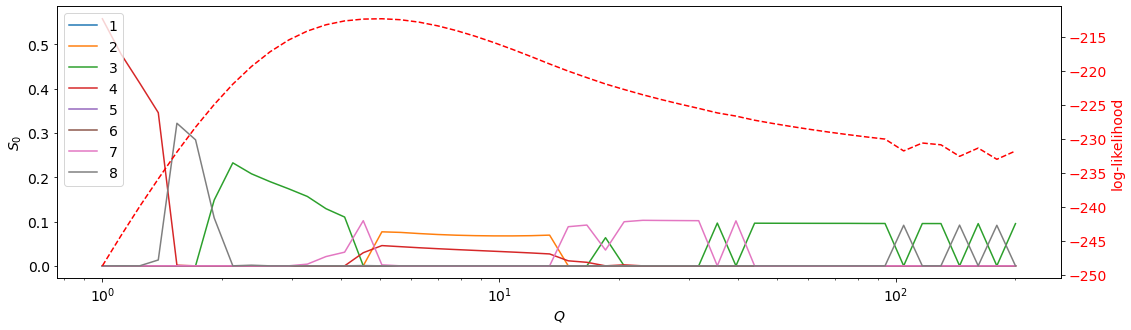

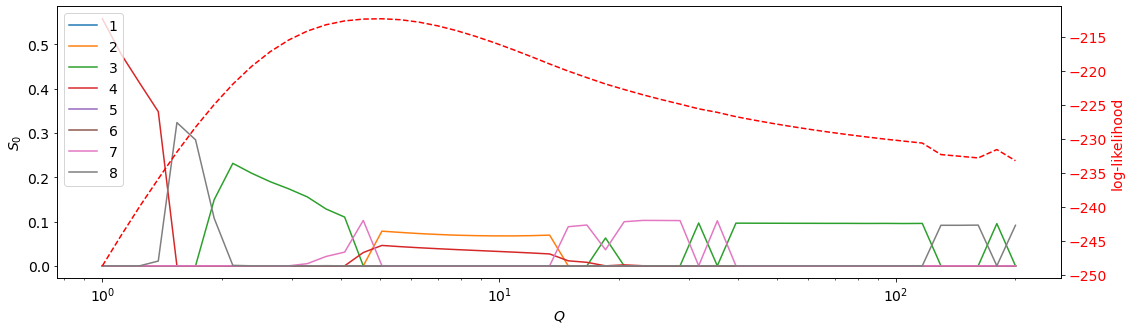

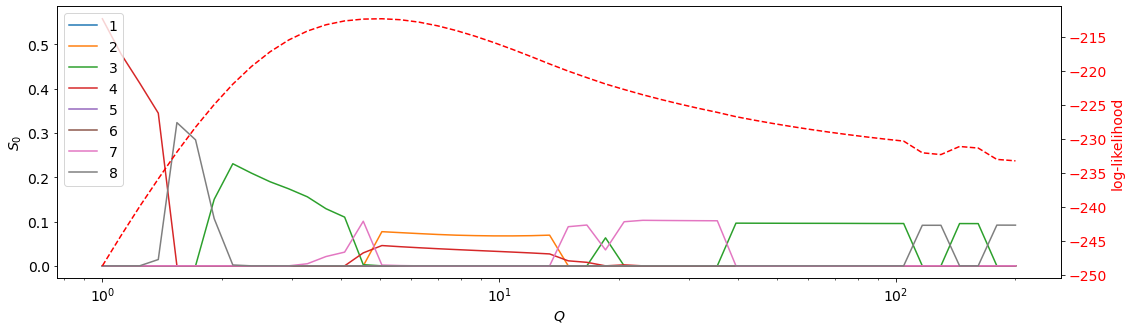

In [4]:
import random
import george
from george import kernels
from sklearn.model_selection import KFold

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)        

def GP(t, y, yerr, S0, Q):
    '''
        6/8 frequency modes
    '''
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/8), np.log(2*np.pi/2))) 
    k01 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2899.022e-6/60)), bounds=bounds) # 2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520
    k02 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)), bounds=bounds)
    k03 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3168.618e-6/60)), bounds=bounds)
    k04 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)), bounds=bounds)
    
    k11 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2828.150e-6/60)), bounds=bounds) # 2828.150e-3, 2963.322e-3, 3098.140e-3
    k12 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2963.322e-6/60)), bounds=bounds)
    k13 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3098.140e-6/60)), bounds=bounds)    
    k14 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3233.139e-6/60)), bounds=bounds)    
    
    k01.freeze_parameter("log_Q")
    k01.freeze_parameter("log_omega0")
    k02.freeze_parameter("log_Q")
    k02.freeze_parameter("log_omega0")
    k03.freeze_parameter("log_Q")
    k03.freeze_parameter("log_omega0")
    k04.freeze_parameter("log_Q")
    k04.freeze_parameter("log_omega0")
    k11.freeze_parameter("log_Q")
    k11.freeze_parameter("log_omega0")
    k12.freeze_parameter("log_Q")
    k12.freeze_parameter("log_omega0")    
    k13.freeze_parameter("log_Q")
    k13.freeze_parameter("log_omega0")    
    k14.freeze_parameter("log_Q")
    k14.freeze_parameter("log_omega0")
    # kernel = k01 + k02 + k03 + k11 + k12 + k13
    kernel = k01 + k02 + k03 + k04 + k11 + k12 + k13 + k14

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp


date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

# New #
# idx_half = (t < max(t)/2)
# t = t[idx_half]
# y = y[idx_half]
# yerr = yerr[idx_half]
#

Q = np.exp(np.linspace(np.log(1),np.log(200), 50))

w0 = 2*np.pi/5

S0_matrix = np.zeros((len(Q), 8))

plt.rcParams.update({'font.size': 14})

for k in range(3):
    
    ll_array = np.zeros(len(Q))
    
    for i in range(len(Q)):    

        S0_reference = np.var(y) / (w0 * Q[i])
        S0 = (np.random.rand() +0.5) * S0_reference
        gp = GP(t, y, yerr, S0, Q[i])
        ll_array[i] = gp.log_likelihood(y)
        
        for j in range(len(gp)):
            S0_matrix[i,j] = np.exp(gp.get_parameter('kernel:terms[' + str(j) + ']:log_S0'))
    
    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot()
    for j in range(len(gp)): 
        ax1.plot(Q, S0_matrix[:,j], label=str(j+1))
        ax1.set_xscale('log')
        ax1.set_ylabel('$S_0$')
        ax1.set_xlabel('$Q$')
        ax1.legend(loc=2)
        
    ax2 = ax1.twinx()
    ax2.plot(Q, ll_array, 'r--')
    ax2.set_ylabel('log-likelihood', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')        
        
    plt.show()

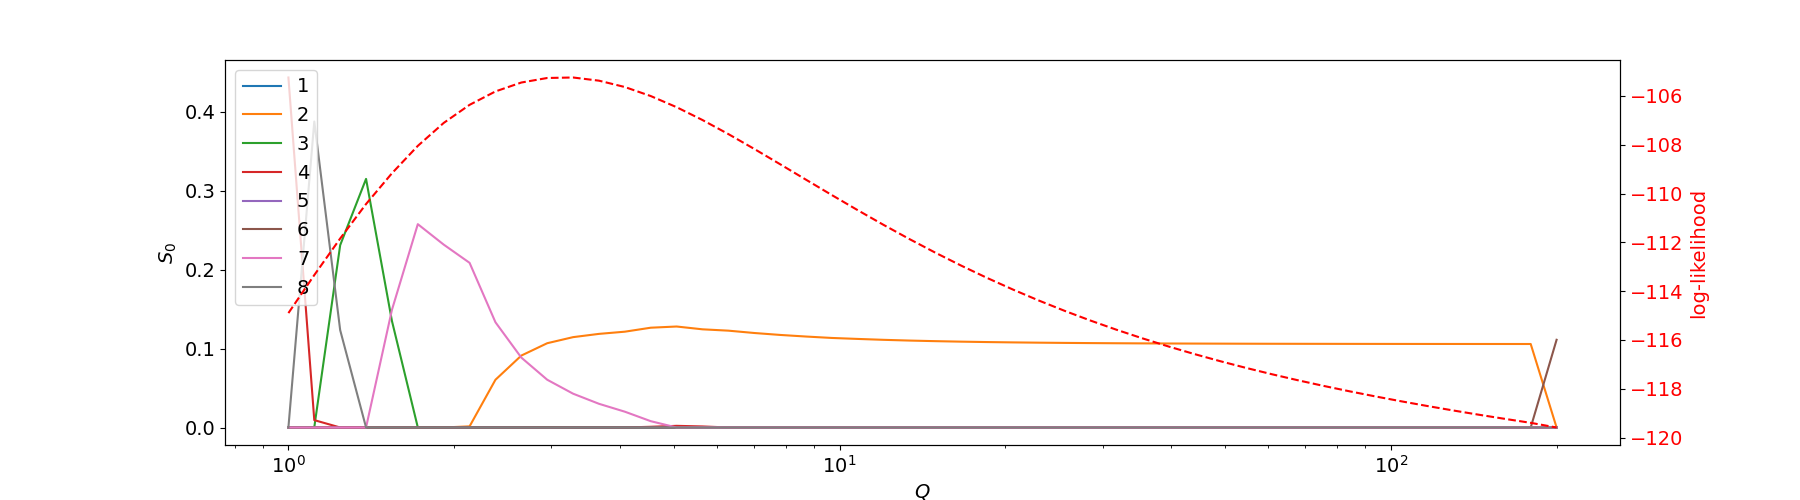

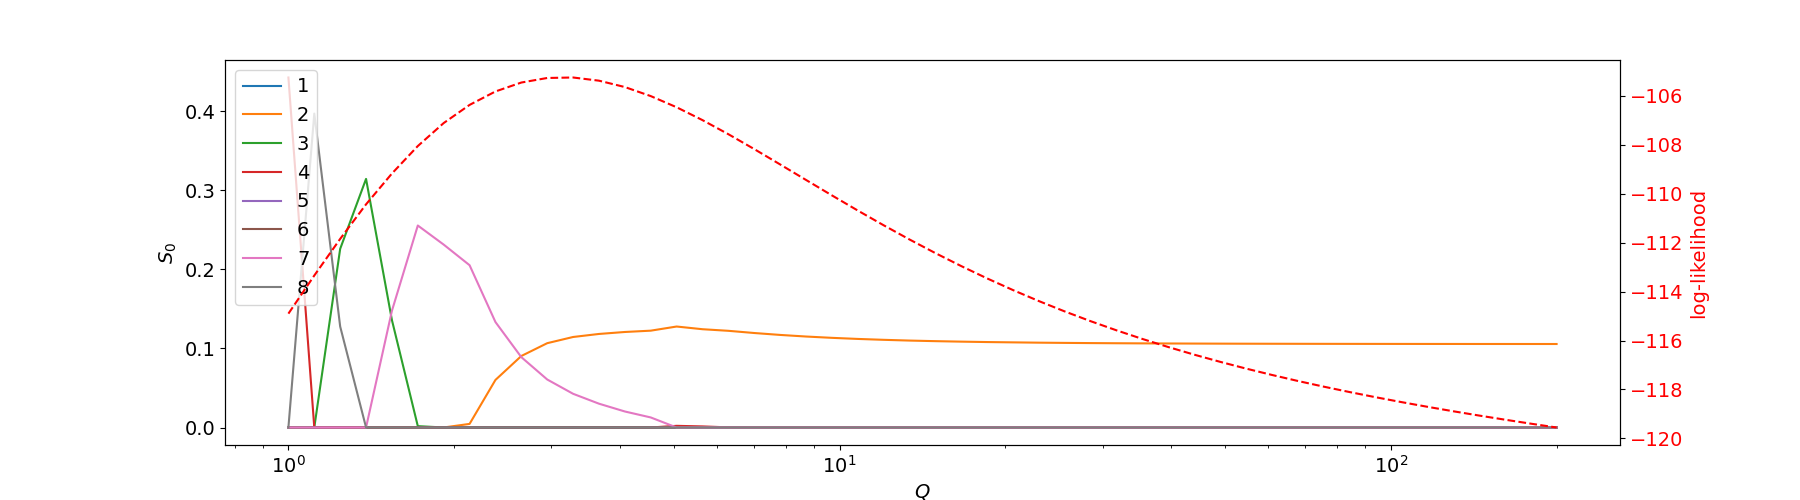

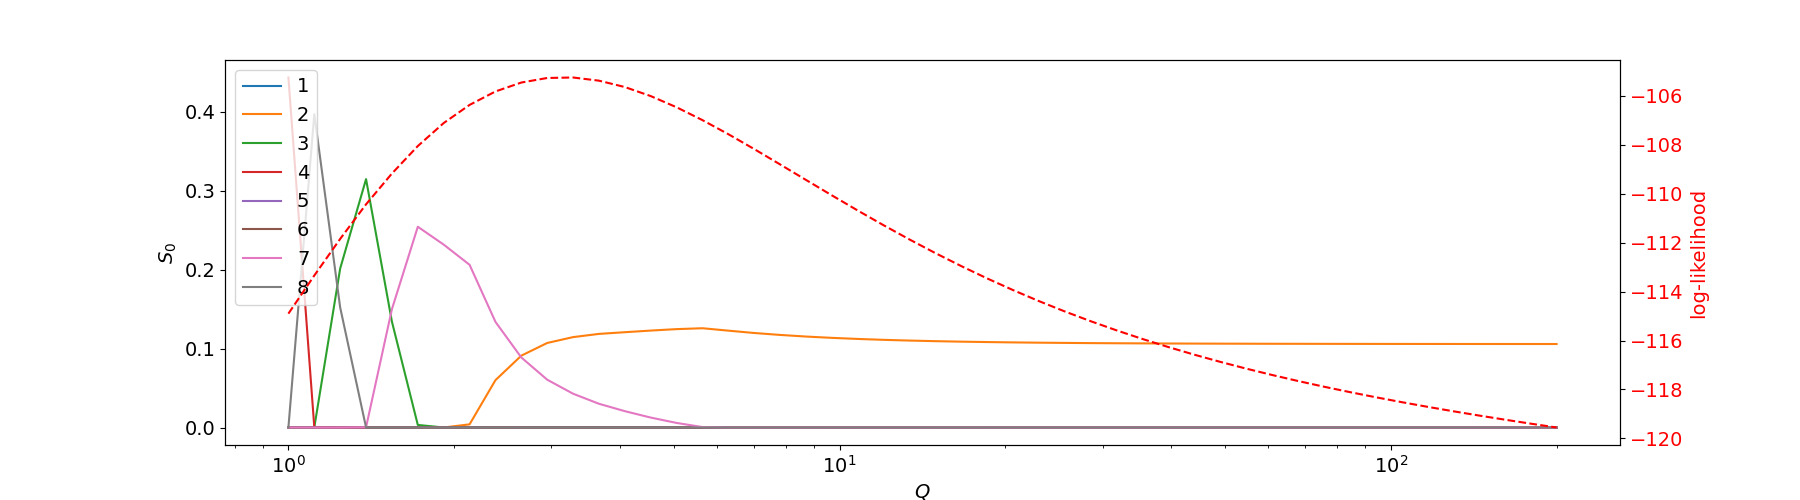

In [49]:
import random
import george
from george import kernels
from sklearn.model_selection import KFold

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)        

def GP(t, y, yerr, S0, Q):
    '''
        6/8 frequency modes
    '''
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/8), np.log(2*np.pi/2))) 
    k01 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2899.022e-6/60)), bounds=bounds) # 2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520
    k02 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)), bounds=bounds)
    k03 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3168.618e-6/60)), bounds=bounds)
    k04 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)), bounds=bounds)
    
    k11 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2828.150e-6/60)), bounds=bounds) # 2828.150e-3, 2963.322e-3, 3098.140e-3
    k12 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2963.322e-6/60)), bounds=bounds)
    k13 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3098.140e-6/60)), bounds=bounds)    
    k14 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3233.139e-6/60)), bounds=bounds)    
    
    k01.freeze_parameter("log_Q")
    k01.freeze_parameter("log_omega0")
    k02.freeze_parameter("log_Q")
    k02.freeze_parameter("log_omega0")
    k03.freeze_parameter("log_Q")
    k03.freeze_parameter("log_omega0")
    k04.freeze_parameter("log_Q")
    k04.freeze_parameter("log_omega0")
    k11.freeze_parameter("log_Q")
    k11.freeze_parameter("log_omega0")
    k12.freeze_parameter("log_Q")
    k12.freeze_parameter("log_omega0")    
    k13.freeze_parameter("log_Q")
    k13.freeze_parameter("log_omega0")    
    k14.freeze_parameter("log_Q")
    k14.freeze_parameter("log_omega0")
    # kernel = k01 + k02 + k03 + k11 + k12 + k13
    kernel = k01 + k02 + k03 + k04 + k11 + k12 + k13 + k14

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp


date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

# New #
idx_half = (t < max(t)/2)
t = t[idx_half]
y = y[idx_half]
yerr = yerr[idx_half]
#

Q = np.exp(np.linspace(np.log(1),np.log(200), 50))

w0 = 2*np.pi/5

S0_matrix = np.zeros((len(Q), 8))

plt.rcParams.update({'font.size': 14})

for k in range(3):
    
    ll_array = np.zeros(len(Q))
    
    for i in range(len(Q)):    

        S0_reference = np.var(y) / (w0 * Q[i])
        S0 = (np.random.rand() +0.5) * S0_reference
        gp = GP(t, y, yerr, S0, Q[i])
        ll_array[i] = gp.log_likelihood(y)
        
        for j in range(len(gp)):
            S0_matrix[i,j] = np.exp(gp.get_parameter('kernel:terms[' + str(j) + ']:log_S0'))
    
    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot()
    for j in range(len(gp)): 
        ax1.plot(Q, S0_matrix[:,j], label=str(j+1))
        ax1.set_xscale('log')
        ax1.set_ylabel('$S_0$')
        ax1.set_xlabel('$Q$')
        ax1.legend(loc=2)
        
    ax2 = ax1.twinx()
    ax2.plot(Q, ll_array, 'r--')
    ax2.set_ylabel('log-likelihood', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')        
        
    plt.show()

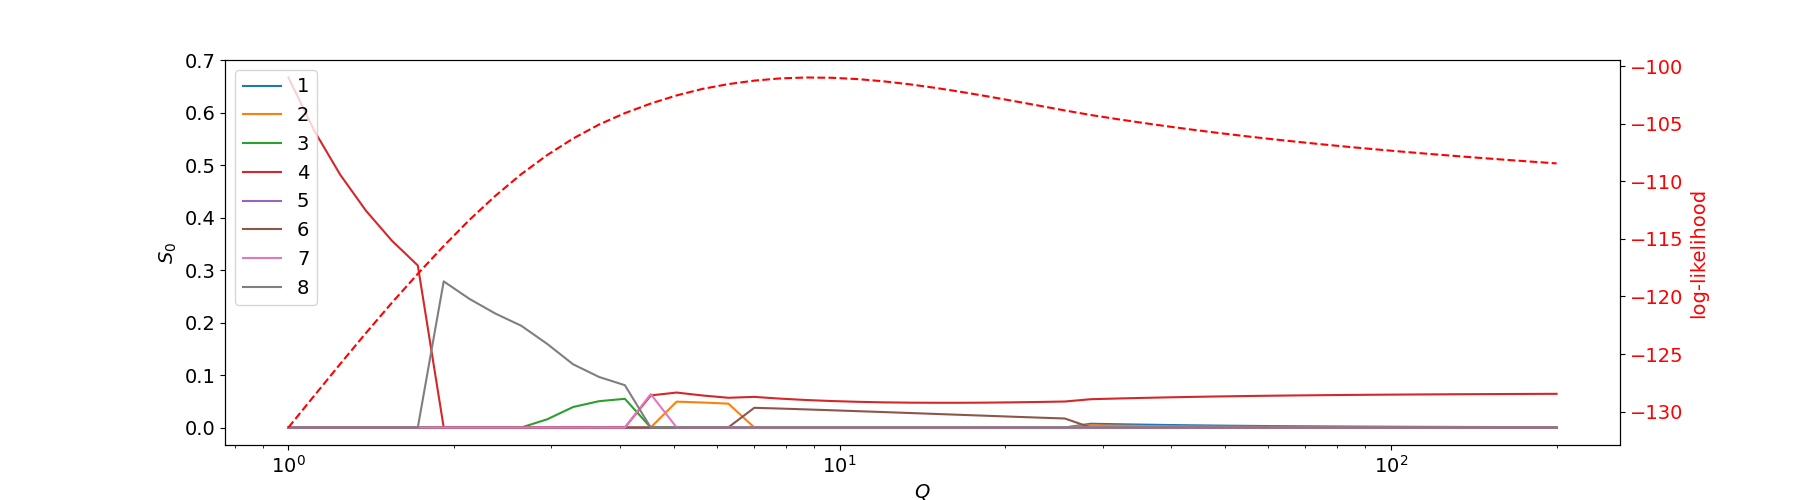

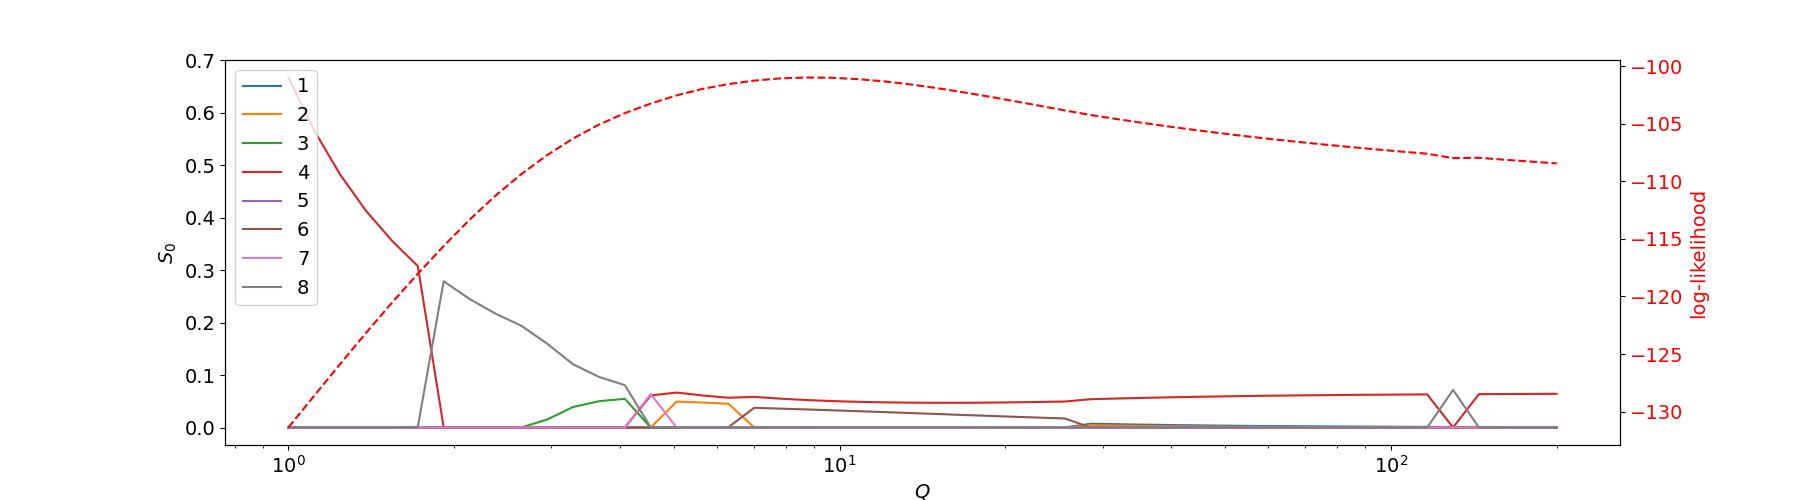

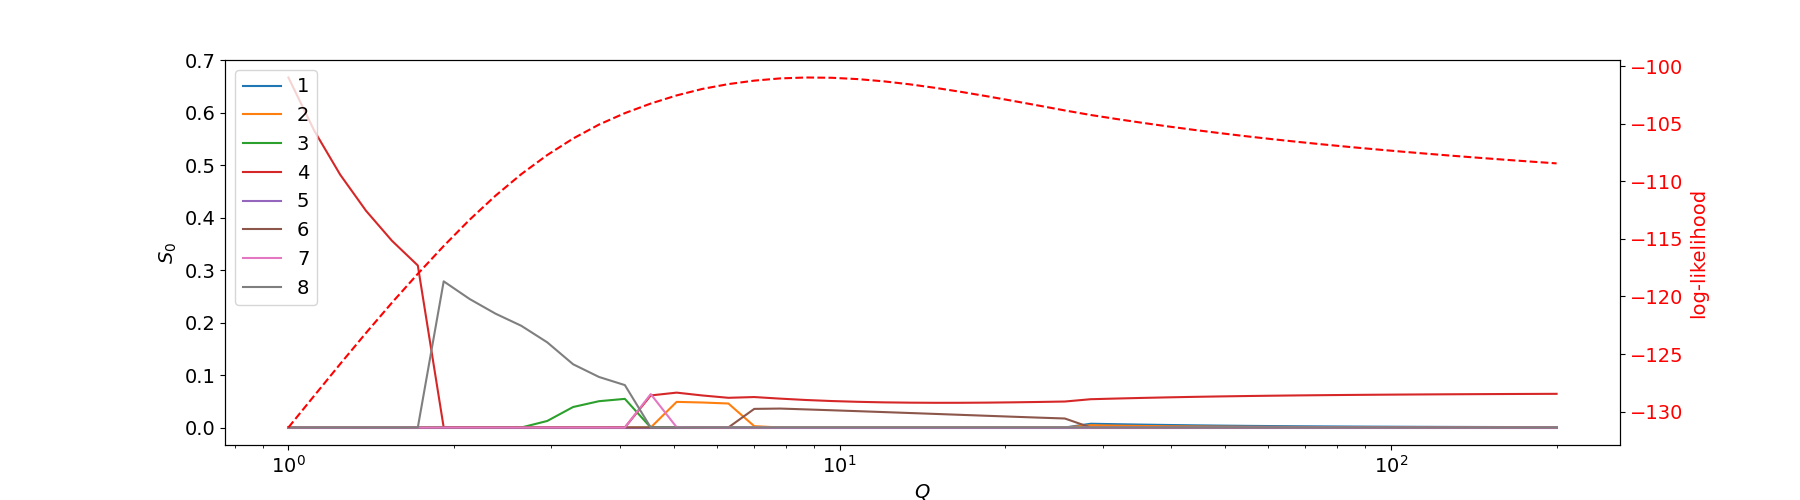

In [50]:
date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

# New #
idx_half = (t > max(t)/2)
t = t[idx_half]
y = y[idx_half]
yerr = yerr[idx_half]
#

Q = np.exp(np.linspace(np.log(1),np.log(200), 50))

w0 = 2*np.pi/5

S0_matrix = np.zeros((len(Q), 8))

plt.rcParams.update({'font.size': 14})

for k in range(3):
    
    ll_array = np.zeros(len(Q))
    
    for i in range(len(Q)):    

        S0_reference = np.var(y) / (w0 * Q[i])
        S0 = (np.random.rand() +0.5) * S0_reference
        gp = GP(t, y, yerr, S0, Q[i])
        ll_array[i] = gp.log_likelihood(y)
        
        for j in range(len(gp)):
            S0_matrix[i,j] = np.exp(gp.get_parameter('kernel:terms[' + str(j) + ']:log_S0'))
    
    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot()
    for j in range(len(gp)): 
        ax1.plot(Q, S0_matrix[:,j], label=str(j+1))
        ax1.set_xscale('log')
        ax1.set_ylabel('$S_0$')
        ax1.set_xlabel('$Q$')
        ax1.legend(loc=2)
        
    ax2 = ax1.twinx()
    ax2.plot(Q, ll_array, 'r--')
    ax2.set_ylabel('log-likelihood', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')        
        
    plt.show()

### Nelder-Mead

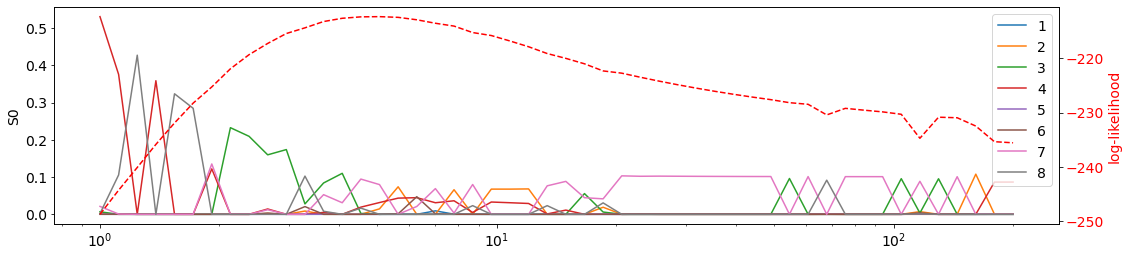

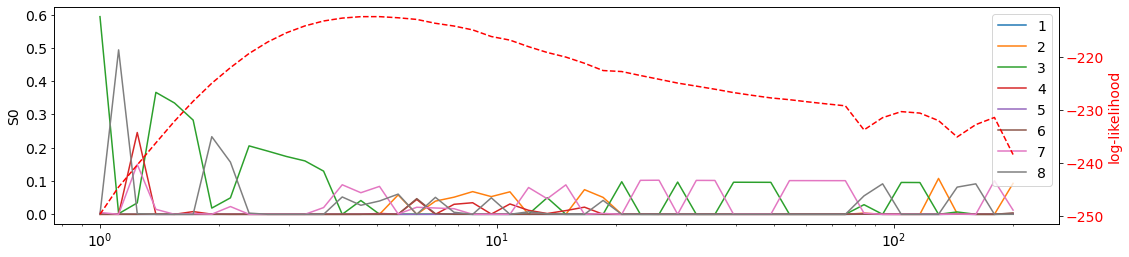

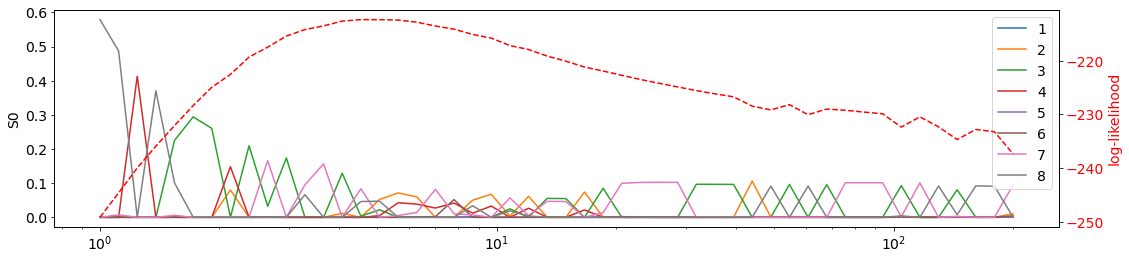

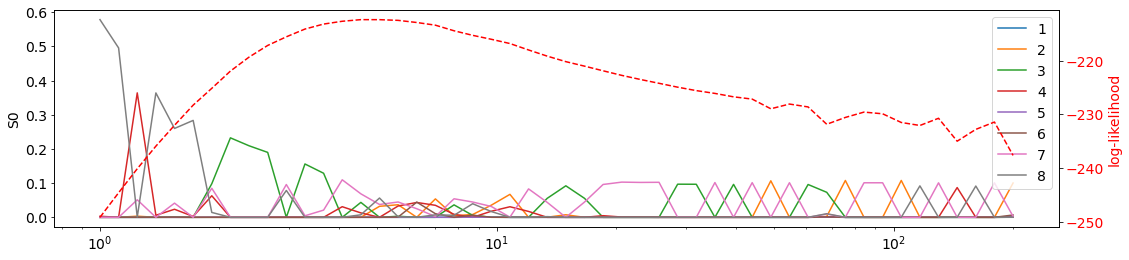

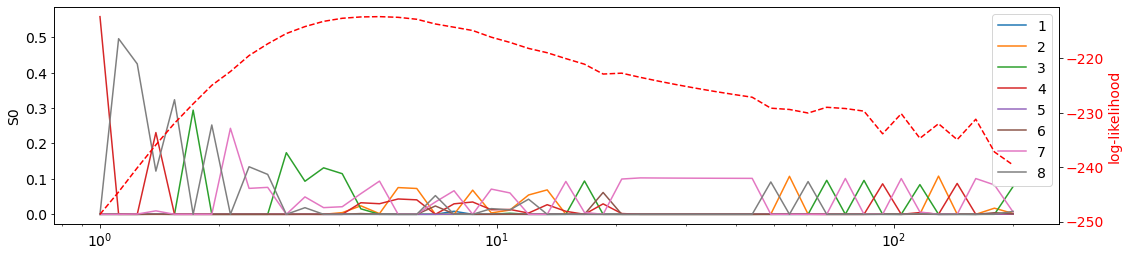

In [4]:
import random
import george
from george import kernels
from sklearn.model_selection import KFold

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)       

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

def GP(t, y, yerr, S0, Q):
    '''
        6/8 frequency modes
    '''
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/8), np.log(2*np.pi/2))) 
    k01 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2899.022e-6/60)), bounds=bounds) # 2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520
    k02 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)), bounds=bounds)
    k03 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3168.618e-6/60)), bounds=bounds)
    k04 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)), bounds=bounds)
    
    k11 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2828.150e-6/60)), bounds=bounds) # 2828.150e-3, 2963.322e-3, 3098.140e-3
    k12 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2963.322e-6/60)), bounds=bounds)
    k13 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3098.140e-6/60)), bounds=bounds)    
    k14 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3233.139e-6/60)), bounds=bounds)    
    
    k01.freeze_parameter("log_Q")
    k01.freeze_parameter("log_omega0")
    k02.freeze_parameter("log_Q")
    k02.freeze_parameter("log_omega0")
    k03.freeze_parameter("log_Q")
    k03.freeze_parameter("log_omega0")
    k04.freeze_parameter("log_Q")
    k04.freeze_parameter("log_omega0")
    k11.freeze_parameter("log_Q")
    k11.freeze_parameter("log_omega0")
    k12.freeze_parameter("log_Q")
    k12.freeze_parameter("log_omega0")    
    k13.freeze_parameter("log_Q")
    k13.freeze_parameter("log_omega0")    
    k14.freeze_parameter("log_Q")
    k14.freeze_parameter("log_omega0")
    # kernel = k01 + k02 + k03 + k11 + k12 + k13
    kernel = k01 + k02 + k03 + k04 + k11 + k12 + k13 + k14

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="Nelder-Mead", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp


date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

Q = np.exp(np.linspace(np.log(1),np.log(200), 50))

w0 = 2*np.pi/5

S0_matrix = np.zeros((len(Q), 8))

plt.rcParams.update({'font.size': 14})

for k in range(5):
    
    ll_array = np.zeros(len(Q))
    
    for i in range(len(Q)):    

        S0_reccommend = np.var(y) / (w0 * Q[i])
        S0 = (np.random.rand() +0.5) * S0_reccommend
        gp = GP(t, y, yerr, S0, Q[i])
        ll_array[i] = gp.log_likelihood(y)
        
        for j in range(len(gp)):
            S0_matrix[i,j] = np.exp(gp.get_parameter('kernel:terms[' + str(j) + ']:log_S0'))
    
    fig = plt.figure(figsize=(18, 4))
    ax1 = fig.add_subplot()
    for j in range(len(gp)): 
        ax1.plot(Q, S0_matrix[:,j], label=str(j+1))
        ax1.set_xscale('log')
        ax1.set_ylabel('S0')
        ax1.legend(loc=1)
        
    ax2 = ax1.twinx()
    ax2.plot(Q, ll_array, 'r--')
    ax2.set_ylabel('log-likelihood', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')        
        
    plt.show()

# log-likehiood as a funciton of S0_1, S0_2, ...

Update the GP funcion: freeze S0 hypeeparameters except S0_2 and S0_4.

In [29]:
def GP(t, y, yerr, S0, S0_3, S0_4, Q):
    '''
        6/8 frequency modes
    '''
    bounds = dict(log_S0=(-10, 0), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/8), np.log(2*np.pi/2))) 
    k01 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2899.022e-6/60)), bounds=bounds) # 2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520
    k02 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)), bounds=bounds)
    k03 = terms.SHOTerm(log_S0=np.log(S0_3), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3168.618e-6/60)), bounds=bounds)
    k04 = terms.SHOTerm(log_S0=np.log(S0_4), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)), bounds=bounds)
    
    k11 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2828.150e-6/60)), bounds=bounds) # 2828.150e-3, 2963.322e-3, 3098.140e-3
    k12 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2963.322e-6/60)), bounds=bounds)
    k13 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3098.140e-6/60)), bounds=bounds)    
    k14 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3233.139e-6/60)), bounds=bounds)    
    
    k01.freeze_parameter("log_Q")
    k01.freeze_parameter("log_omega0")
    k02.freeze_parameter("log_Q")
    k02.freeze_parameter("log_omega0")
    k03.freeze_parameter("log_Q")
    k03.freeze_parameter("log_S0")        #new    
    k03.freeze_parameter("log_omega0")
    k04.freeze_parameter("log_Q")
    k04.freeze_parameter("log_S0")        #new    
    k04.freeze_parameter("log_omega0")
    k11.freeze_parameter("log_Q")
    k11.freeze_parameter("log_omega0")
    k12.freeze_parameter("log_Q")
    k12.freeze_parameter("log_omega0")    
    k13.freeze_parameter("log_Q")
    k13.freeze_parameter("log_omega0")    
    k14.freeze_parameter("log_Q")
    k14.freeze_parameter("log_omega0")
    # kernel = k01 + k02 + k03 + k11 + k12 + k13
    kernel = k01 + k02 + k03 + k04 + k11 + k12 + k13 + k14

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

In [30]:
Q = 6
S0 = np.var(y) / (w0 * Q)
N = 10
S0_3 = np.exp(np.linspace(np.log(1e-2),np.log(1e-1),N))
S0_4 = np.exp(np.linspace(np.log(1e-2),np.log(1e-1),N))
ll_matrix = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        gp = GP(t, y, yerr, S0, S0_3[i], S0_4[j], Q)
        ll_matrix[i,j] = gp.log_likelihood(y)

X, Y = np.meshgrid(S0_3, S0_4)
Z = ll_matrix

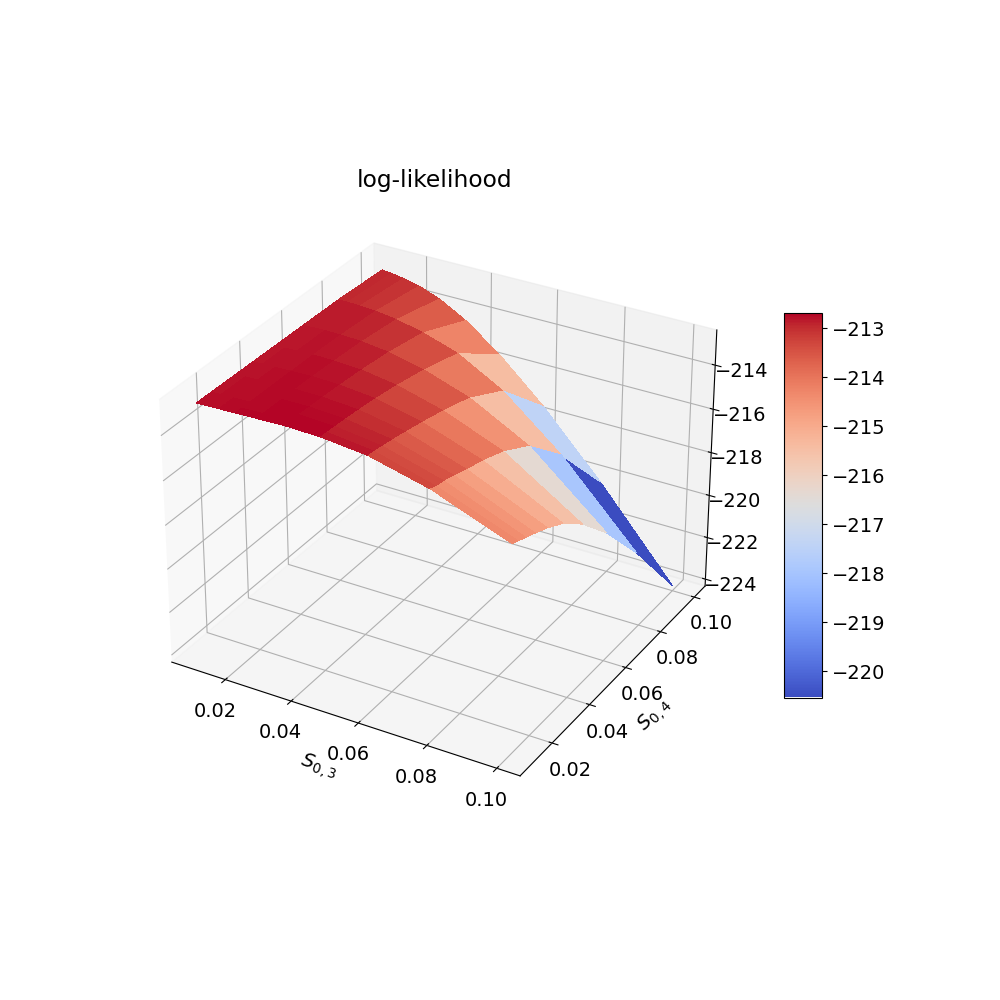

In [31]:
%matplotlib widget
from matplotlib import cm

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
#                 cmap='viridis', edgecolor='none')
ax.set_title('log-likelihood')   
ax.set_xlabel('$S_{0,3}$')
ax.set_ylabel('$S_{0,4}$')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

In [32]:
def GP(t, y, yerr, S0, S0_2, S0_4, Q):
    '''
        6/8 frequency modes
    '''
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/8), np.log(2*np.pi/2))) 
    k01 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2899.022e-6/60)), bounds=bounds) # 2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520
    k02 = terms.SHOTerm(log_S0=np.log(S0_2), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)), bounds=bounds)
    k03 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3168.618e-6/60)), bounds=bounds)
    k04 = terms.SHOTerm(log_S0=np.log(S0_4), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)), bounds=bounds)
    
    k11 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2828.150e-6/60)), bounds=bounds) # 2828.150e-3, 2963.322e-3, 3098.140e-3
    k12 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2963.322e-6/60)), bounds=bounds)
    k13 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3098.140e-6/60)), bounds=bounds)    
    k14 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3233.139e-6/60)), bounds=bounds)    
    
    k01.freeze_parameter("log_Q")
    k01.freeze_parameter("log_omega0")
    k02.freeze_parameter("log_Q")
    k02.freeze_parameter("log_S0")        #new
    k02.freeze_parameter("log_omega0")
    k03.freeze_parameter("log_Q")
    k03.freeze_parameter("log_omega0")
    k04.freeze_parameter("log_Q")
    k04.freeze_parameter("log_S0")        #new    
    k04.freeze_parameter("log_omega0")
    k11.freeze_parameter("log_Q")
    k11.freeze_parameter("log_omega0")
    k12.freeze_parameter("log_Q")
    k12.freeze_parameter("log_omega0")    
    k13.freeze_parameter("log_Q")
    k13.freeze_parameter("log_omega0")    
    k14.freeze_parameter("log_Q")
    k14.freeze_parameter("log_omega0")
    # kernel = k01 + k02 + k03 + k11 + k12 + k13
    kernel = k01 + k02 + k03 + k04 + k11 + k12 + k13 + k14

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

In [33]:
Q = 6
S0 = np.var(y) / (w0 * Q)
N = 10
S0_2 = np.exp(np.linspace(np.log(1e-2),np.log(1e-1),N))
S0_4 = np.exp(np.linspace(np.log(1e-2),np.log(1e-1),N))
ll_matrix = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        gp = GP(t, y, yerr, S0, S0_2[i], S0_4[j], Q)
        ll_matrix[i,j] = gp.log_likelihood(y)

X, Y = np.meshgrid(S0_2, S0_4)
Z = ll_matrix

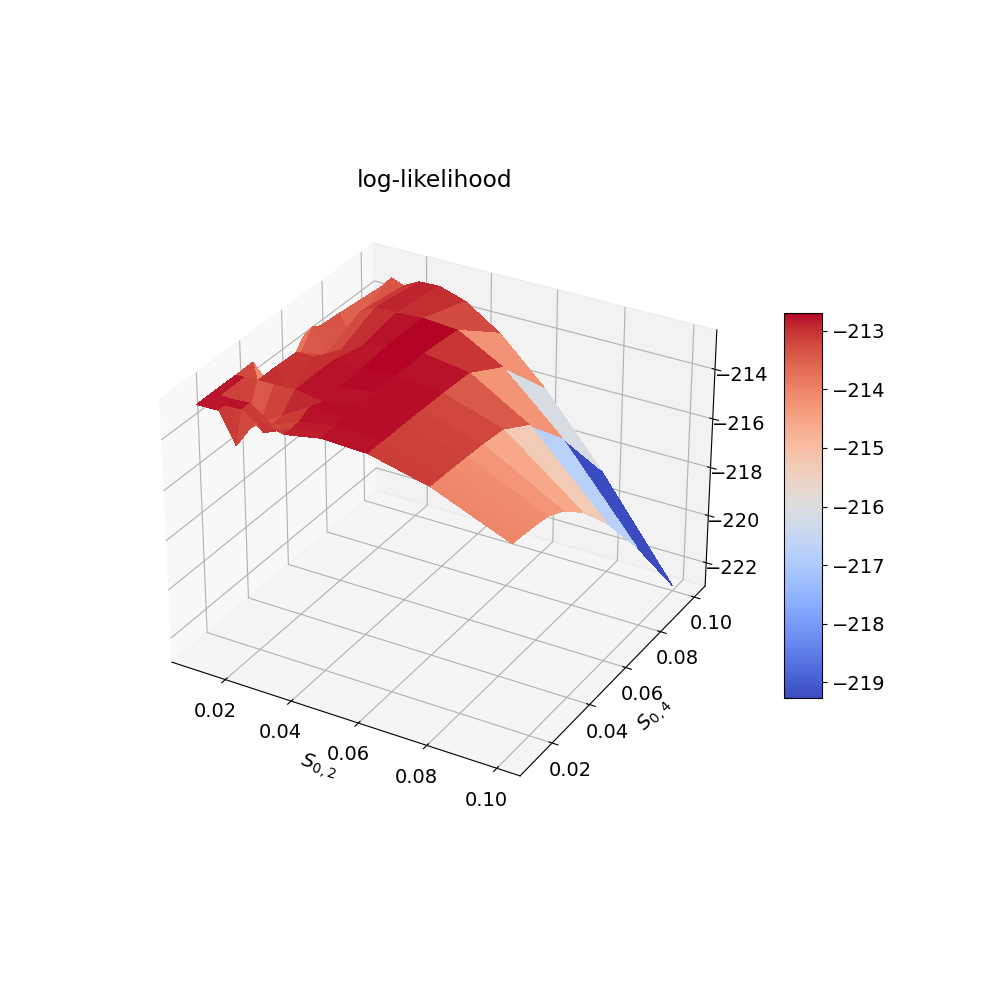

In [34]:
%matplotlib widget
from matplotlib import cm

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('log-likelihood')   
ax.set_xlabel('$S_{0,2}$')
ax.set_ylabel('$S_{0,4}$')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

In [35]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -15.0),
             ('kernel:terms[2]:log_S0', -15.0),
             ('kernel:terms[4]:log_S0', -15.0),
             ('kernel:terms[5]:log_S0', -15.0),
             ('kernel:terms[6]:log_S0', -15.0),
             ('kernel:terms[7]:log_S0', -15.0)])

In [36]:
Q = 6
S0 = np.var(y) / (w0 * Q)
N = 20
S0_2 = np.exp(np.linspace(np.log(1e-2),np.log(1e-1),N))
S0_4 = np.exp(np.linspace(np.log(1e-2),np.log(1e-1),N))
ll_matrix = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        gp = GP(t, y, yerr, S0, S0_2[i], S0_4[j], Q)
        ll_matrix[i,j] = gp.log_likelihood(y)

X, Y = np.meshgrid(S0_2, S0_4)
Z = ll_matrix

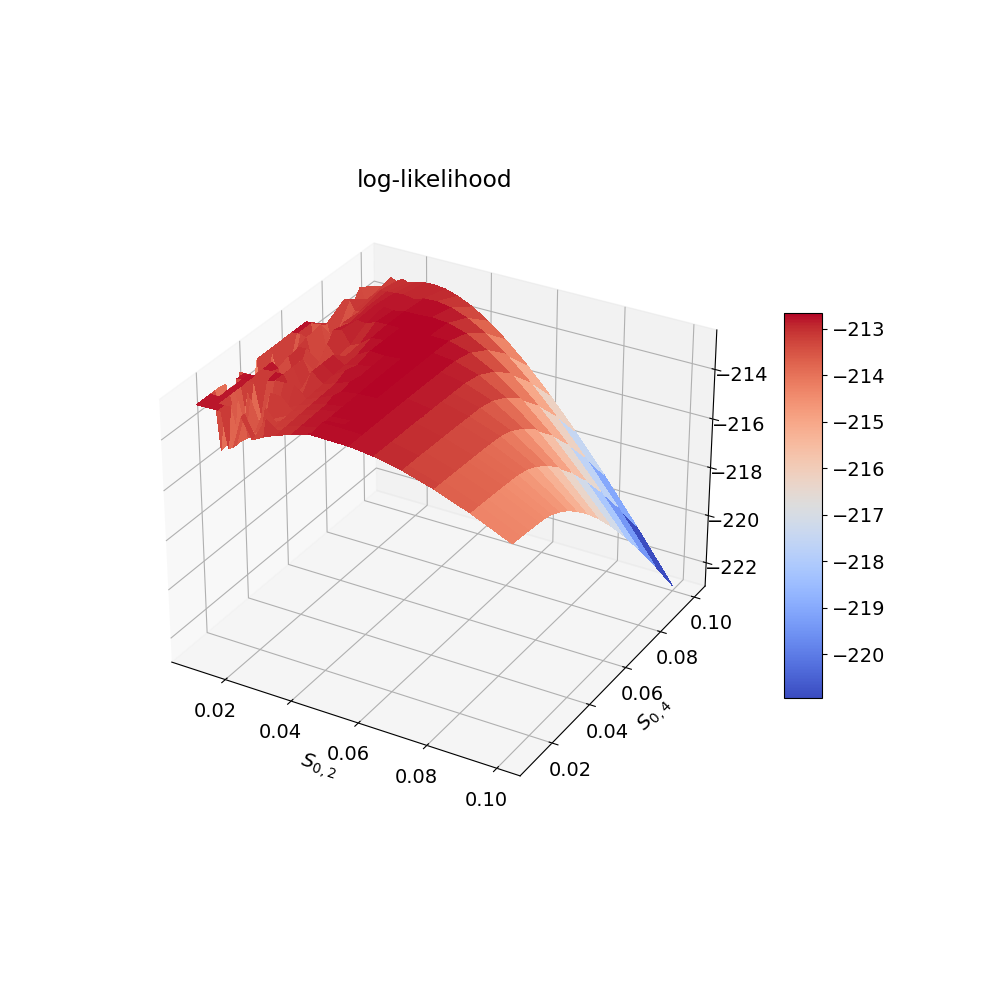

In [37]:
%matplotlib widget
from matplotlib import cm

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('log-likelihood')   
ax.set_xlabel('$S_{0,2}$')
ax.set_ylabel('$S_{0,4}$')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

In [46]:
def GP(t, y, yerr, S0, Q):
    '''
        6/8 frequency modes
    '''
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/8), np.log(2*np.pi/2))) 
    k01 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2899.022e-6/60)), bounds=bounds) # 2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520
    k02 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)), bounds=bounds)
    k03 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3168.618e-6/60)), bounds=bounds)
    k04 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)), bounds=bounds)
    
    k11 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2828.150e-6/60)), bounds=bounds) # 2828.150e-3, 2963.322e-3, 3098.140e-3
    k12 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2963.322e-6/60)), bounds=bounds)
    k13 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3098.140e-6/60)), bounds=bounds)    
    k14 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3233.139e-6/60)), bounds=bounds)    
    
    k01.freeze_parameter("log_Q")
    k01.freeze_parameter("log_omega0")
    k02.freeze_parameter("log_Q")
    k02.freeze_parameter("log_omega0")
    k03.freeze_parameter("log_Q")
    k03.freeze_parameter("log_omega0")
    k04.freeze_parameter("log_Q")
    k04.freeze_parameter("log_omega0")
    k11.freeze_parameter("log_Q")
    k11.freeze_parameter("log_omega0")
    k12.freeze_parameter("log_Q")
    k12.freeze_parameter("log_omega0")    
    k13.freeze_parameter("log_Q")
    k13.freeze_parameter("log_omega0")    
    k14.freeze_parameter("log_Q")
    k14.freeze_parameter("log_omega0")
    # kernel = k01 + k02 + k03 + k11 + k12 + k13
    kernel = k01 + k02 + k03 + k04 + k11 + k12 + k13 + k14

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp


date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

# Q = np.exp(np.linspace(np.log(1),np.log(200), 50))
Q = np.array([6])

w0 = 2*np.pi/5

S0_matrix = np.zeros((len(Q), 8))

plt.rcParams.update({'font.size': 14})

    
ll_array = np.zeros(len(Q))

for i in range(len(Q)):    

    S0_reference = np.var(y) / (w0 * Q[i])
    S0 = (np.random.rand() +0.5) * S0_reference
    gp = GP(t, y, yerr, S0, Q[i])
    ll_array[i] = gp.log_likelihood(y)

    print(np.exp(gp.get_parameter('kernel:terms[1]:log_S0')))
    print(np.exp(gp.get_parameter('kernel:terms[3]:log_S0')))



0.07329673992547753
0.04193968061395867


In [42]:
S0_matrix

array([[3.05904425e-07, 7.39444002e-02, 1.43092776e-06, 4.18684949e-02,
        3.05904200e-07, 7.17293107e-06, 1.07720484e-06, 4.78445831e-07]])

In [43]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -14.999993119651283),
             ('kernel:terms[1]:log_S0', -2.6044418172643726),
             ('kernel:terms[2]:log_S0', -13.457187544287825),
             ('kernel:terms[3]:log_S0', -3.1732216460059908),
             ('kernel:terms[4]:log_S0', -14.999993854431228),
             ('kernel:terms[5]:log_S0', -11.845196190360435),
             ('kernel:terms[6]:log_S0', -13.741140984109496),
             ('kernel:terms[7]:log_S0', -14.5527228380656)])